In [1]:
import pickle
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from scipy.ndimage.measurements import label
from features import convert_cspace, bin_spatial, color_hist, get_hog_features
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
# Load the latest saved model
latest_model = max(glob.glob('./saved_models/*.p'))
with open(latest_model, 'rb') as f:
    dist_pickle = pickle.load(f)
    print('Successfully loaded {}'.format(latest_model))

svc = dist_pickle['svc']
X_scaler = dist_pickle['X_scaler']
params = dist_pickle['params']

Successfully loaded ./saved_models/2017-03-05T19:33:09Z|test_acc=0.9963|train_samples=14208|test_samples=3552.p


In [3]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for box in bboxes:
        if not box:
            continue            
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, cspace, spatial_size, hist_bins, hist_range, 
              orient, pix_per_cell, cell_per_block, hog_channel):
    
    bboxes = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_cspace(img_tosearch, cspace)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.ravel((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get spatial and color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bboxes

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [5]:
class VehicleDetector:
    
    def __init__(self, svc, X_scaler, params, threshold=1, keep=9):
        self.svc = svc
        self.X_scaler = X_scaler
        self.params = params
        self.threshold = threshold
        self.heatmaps = deque(maxlen=keep)
        
    def __get_bboxes_for_all_frames(self):
        flatten = lambda l: [item for sublist in l for item in sublist]
        return flatten(self.frame_detections)
                
    def __detect_bboxes(self, img, small_scale=0.8, medium_scale=1.5, large_scale=2.5):
        bboxes = []
        # small scale
        bboxes += find_cars(img, 400, 450, small_scale, self.svc, self.X_scaler, **self.params)
        # medium scale
        bboxes += find_cars(img, 400, 550, medium_scale, self.svc, self.X_scaler, **self.params)
         # large scale
        bboxes += find_cars(img, 400, 650, large_scale, self.svc, self.X_scaler, **self.params)
        return bboxes
        
    def __heatmap_and_threshold(self, img, bboxes):
        heat = np.zeros_like(img[:,:,0]).astype(np.float32)
        # Add heat to each box in box list
        heat = add_heat(heat, bboxes)
        
        # Apply threshold to help remove false positives in this frame
        heat = apply_threshold(heat, self.threshold)

        # Clip to dtype range    
        heatmap = np.clip(heat, 0, 255)
        
        # Add the new frame's heatmap to the collection of heatmaps
        self.heatmaps.appendleft(heatmap)
        
        # calc the average heatmap score
        avg_heatmap = np.array(self.heatmaps).mean(axis=0)
        
        # threshold the average
        avg_heatmap = apply_threshold(avg_heatmap, self.threshold)
        
        # return average threshold
        return avg_heatmap
    
    def process_frame(self, img):
        bboxes = self.__detect_bboxes(img)
        heatmap = self.__heatmap_and_threshold(img, bboxes)
        labels = label(heatmap)
        return draw_labeled_bboxes(img, labels)
        
        

In [6]:
output = './output_test_video.mp4'
vid = VideoFileClip('./test_video.mp4')
vehicle_detector = VehicleDetector(svc, X_scaler, params)
processed = vid.fl_image(vehicle_detector.process_frame)
%time processed.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video ./output_test_video.mp4
[MoviePy] Writing video ./output_test_video.mp4


 97%|█████████▋| 38/39 [00:15<00:00,  2.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_test_video.mp4 

CPU times: user 14 s, sys: 617 ms, total: 14.6 s
Wall time: 16.1 s


In [7]:
# output = './output_project_video.mp4'
# vid = VideoFileClip('./project_video.mp4')
# vehicle_detector = VehicleDetector(svc, X_scaler, params)
# processed = vid.fl_image(vehicle_detector.process_frame)
# %time processed.write_videofile(output, audio=False)

# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(output))

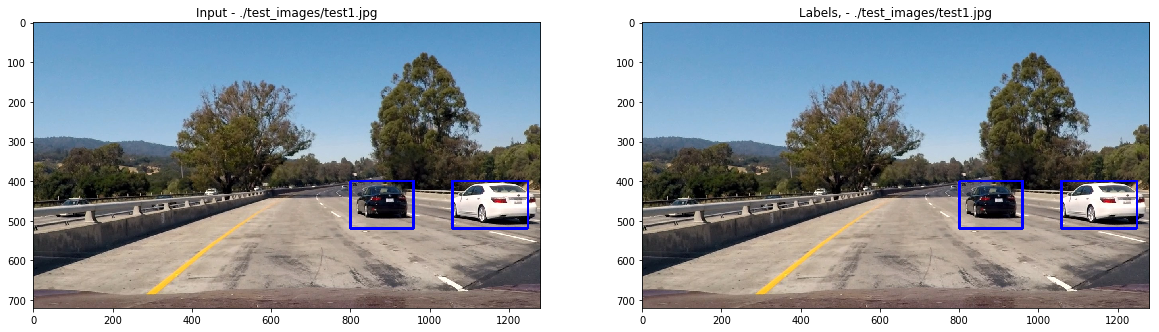

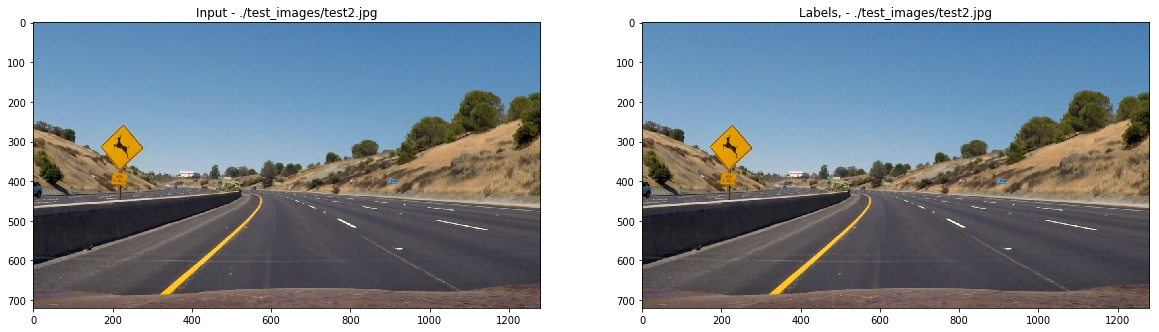

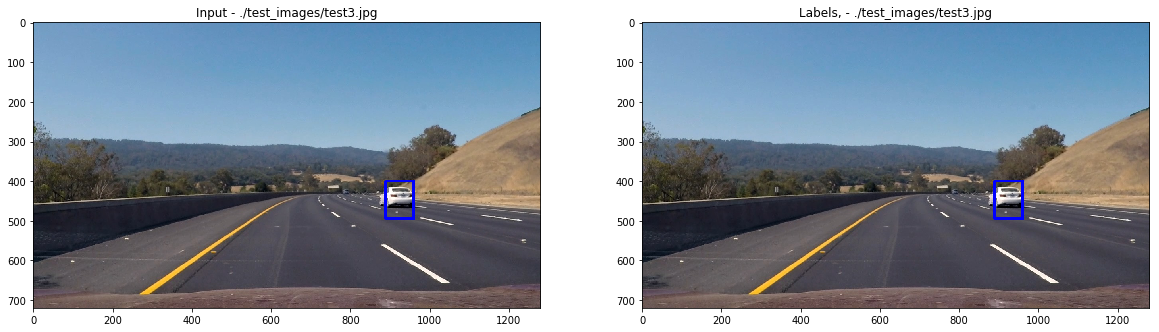

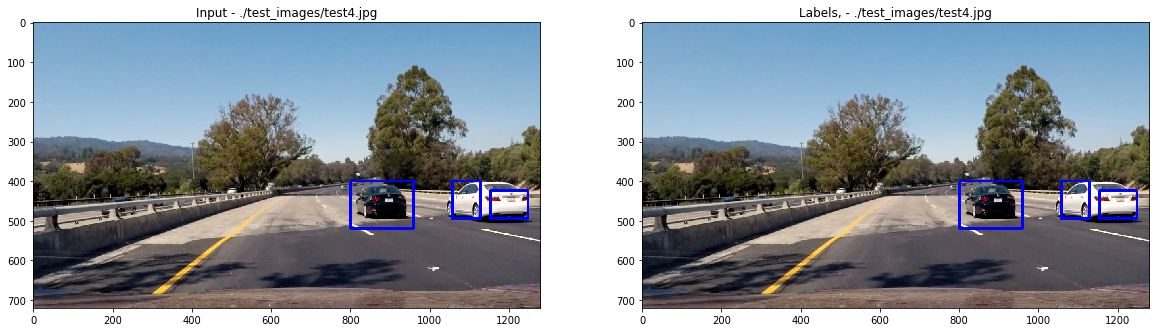

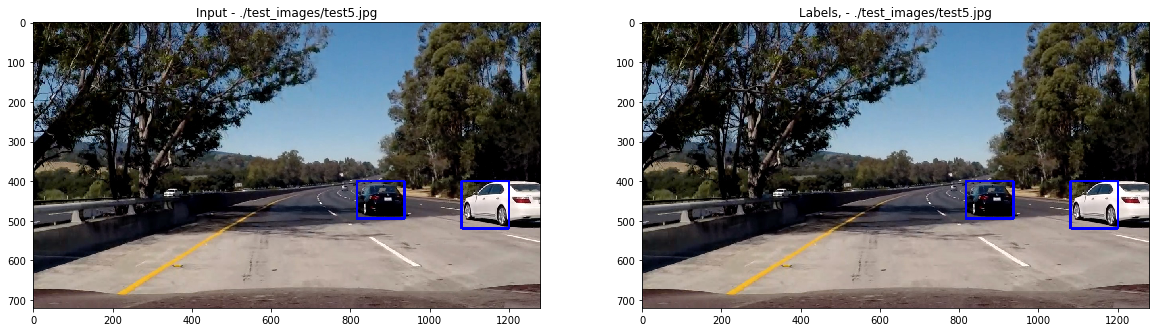

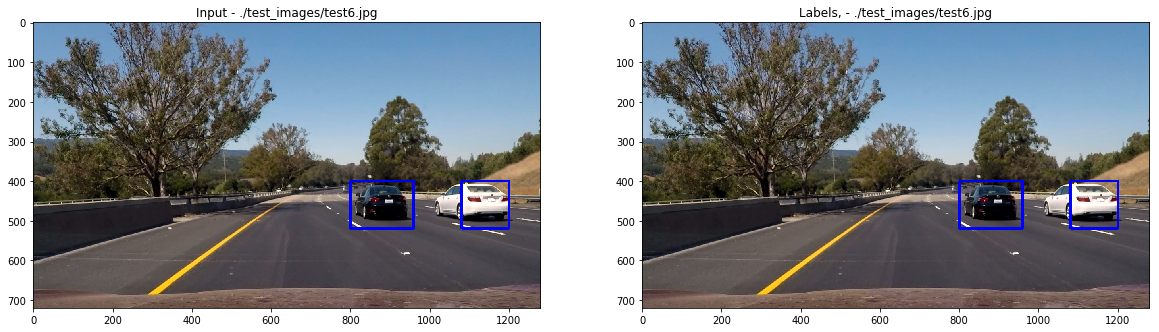

In [8]:
test_images = glob.glob('./test_images/*.jpg')

for fname in glob.glob('./test_images/*.jpg'):
    img = mpimg.imread(fname) 
    detector = VehicleDetector(svc, X_scaler, params)
    res = detector.process_frame(img)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Input - {}'.format(fname))
    ax1.imshow(img)
    
    ax2.set_title('Labels, - {}'.format(fname))
    ax2.imshow(img)